In [1]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("Environment configured for Kaggle runtime.")


Environment configured for Kaggle runtime.


In [5]:
import numpy as np
import pandas as pd
import os, gc
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers, models

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


In [31]:

IMG_DIR = "/kaggle/input/drtid-data/DRTiD/Original Images"
TRAIN_CSV = "/kaggle/input/drtid-data/DRTiD/Ground Truths/DR_grade/a. DR_grade_Training.csv"
TEST_CSV  = "/kaggle/input/drtid-data/DRTiD/Ground Truths/DR_grade/b. DR_grade_Testing.csv"

IMG_SIZE = (299, 299)         
BATCH_SIZE = 16
SEED = 42


# LOAD CSVs & EXPAND (Macula + Optic as separate images)

In [6]:



train_raw = pd.read_csv(TRAIN_CSV)
test_raw  = pd.read_csv(TEST_CSV)

def expand_df(df):
    # Macula images
    mac = pd.DataFrame({
        "filename": df["Macula"].astype(str) + ".jpg",
        "label":    (df["Grade"] > 0).astype(int)
    })
    # Optic images
    optic = pd.DataFrame({
        "filename": df["Optic disc"].astype(str) + ".jpg",
        "label":    (df["Grade"] > 0).astype(int)
    })
    full = pd.concat([mac, optic], ignore_index=True)
    return full

train_df = expand_df(train_raw)
test_df  = expand_df(test_raw)

print("Train rows (after expand):", len(train_df))
print("Test rows  (after expand):", len(test_df))
train_df.head()


Train rows (after expand): 2000
Test rows  (after expand): 1100


,filename,label
0,0002_1.jpg,0
1,0003_1.jpg,1
2,0004_1.jpg,1
3,0005_1.jpg,1
4,0006_1.jpg,1


# EDA – Class Distribution & Sample Images


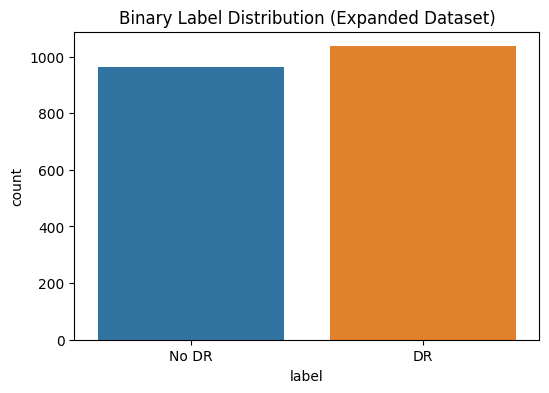


Counts:
label
1    1036
0     964
Name: count, dtype: int64


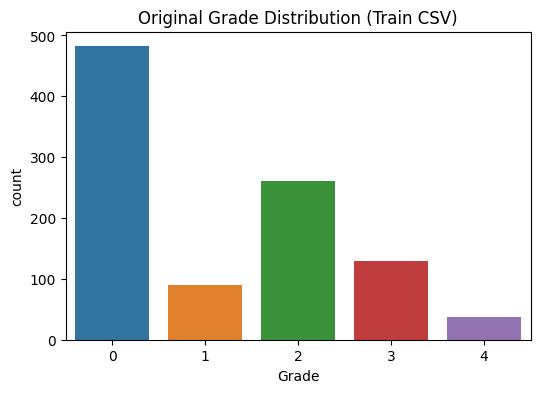

Grade
0    482
2    260
3    130
1     90
4     38
Name: count, dtype: int64


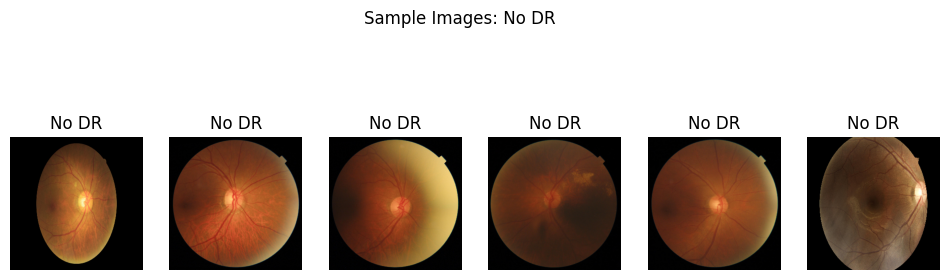

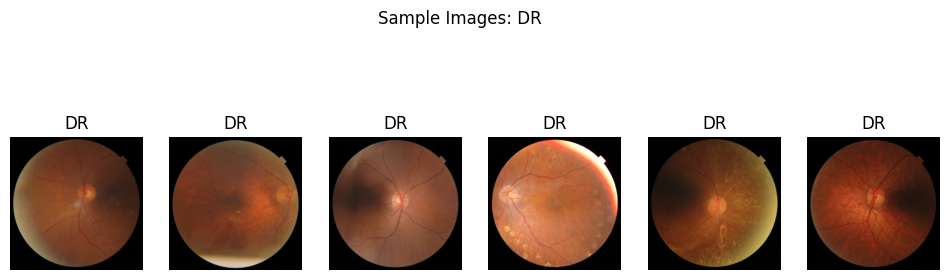

In [32]:

# CLASS DISTRIBUTION AFTER EXPANSION
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x="label")
plt.xticks([0,1], ["No DR", "DR"])
plt.title("Binary Label Distribution (Expanded Dataset)")
plt.show()

print("\nCounts:")
print(train_df["label"].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(data=train_raw, x="Grade")
plt.title("Original Grade Distribution (Train CSV)")
plt.show()

print(train_raw["Grade"].value_counts())
IMG_SIZE = (300, 300)   # or (299, 299) for Xception
RANDOM_STATE = 42
img_dir = IMG_DIR   # for compatibility

def show_samples(df, label, n=6):
    subset = df[df["label"] == label].sample(
        min(n, len(df[df["label"] == label])),
        random_state=RANDOM_STATE
    )

    plt.figure(figsize=(12,4))
    for i, (_, row) in enumerate(subset.iterrows()):
        img_path = os.path.join(img_dir, row["filename"])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("No DR" if label == 0 else "DR")

    plt.suptitle(f"Sample Images: {'No DR' if label == 0 else 'DR'}")
    plt.show()

# Show samples for both classes
show_samples(train_df, 0)
show_samples(train_df, 1)




#  CLASS BALANCE & CLASS WEIGHTS

In [11]:

print("Label counts train:\n", train_df["label"].value_counts())

classes = np.array([0, 1])
cw = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)
class_weights = {0: cw[0], 1: cw[1]}
print("Class weights:", class_weights)


Label counts train:
 label
1    1036
0     964
Name: count, dtype: int64
Class weights: {0: 1.037344398340249, 1: 0.9652509652509652}


# PREPROCESSING: CLAHE + Xception preprocess

In [10]:

def clahe_xception(img):
    # img arrives as float32 [0,255] or [0,1] depending on generator
    img = img.astype(np.uint8)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    img = img.astype(np.float32)
    img = xcep_preprocess(img)   # [-1,1] scaling + channel-wise normalization
    return img


# IMAGE GENERATORS 

In [13]:

train_datagen = ImageDataGenerator(
    preprocessing_function=clahe_xception,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    preprocessing_function=clahe_xception,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=clahe_xception
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",      # numeric 0/1
    subset="training",
    seed=SEED
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="validation",
    shuffle=False,
    seed=SEED
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)


Found 1600 validated image filenames.
Found 400 validated image filenames.
Found 1100 validated image filenames.


# BUILD DUAL-IMAGE-IN-ONE-DATASET XCEPTION MODEL (BINARY)
#    (Standard single-input CNN, but trained on both macula & optic)

In [14]:

tf.keras.backend.clear_session()
gc.collect()

base = Xception(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base.trainable = False  # stage 1

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, output)
model.summary()


I0000 00:00:1763650483.588309      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763650483.589048      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,976,361 (83.83 MB)

 Trainable params: 1,114,881 (4.25 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

# FINE-TUNE XCEPTION

In [17]:

base.trainable = True
for layer in base.layers[:-60]:  # unfreeze last 60 layers
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

cb2 = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
]

history2 = model.fit(
    train_gen,
    epochs=40,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=cb2
)


Epoch 1/40


E0000 00:00:1763651720.555705     151 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763651720.698097     151 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 724ms/step - accuracy: 0.6435 - loss: 0.6431 - val_accuracy: 0.7250 - val_loss: 0.5481 - learning_rate: 1.0000e-05
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 706ms/step - accuracy: 0.6991 - loss: 0.5895 - val_accuracy: 0.7475 - val_loss: 0.5116 - learning_rate: 1.0000e-05
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 703ms/step - accuracy: 0.7214 - loss: 0.5475 - val_accuracy: 0.7625 - val_loss: 0.5028 - learning_rate: 1.0000e-05
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 689ms/step - accuracy: 0.7235 - loss: 0.5329 - val_accuracy: 0.7600 - val_loss: 0.4922 - learning_rate: 1.0000e-05
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 694ms/step - accuracy: 0.7076 - loss: 0.5544 - val_accuracy: 0.7800 - val_loss: 0.4946 - learning_rate: 1.0000e-05
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 730ms/step - accuracy: 0.7130 - loss: 0.5448 - val_accuracy: 0.7800 - val_loss: 0.4883 - learning_rate: 1.0000e-05
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 712ms/step - 

In [18]:
# =========================================================
# SAVE XCEPTION MODEL in Kaggle
# =========================================================
save_path = "/kaggle/working/xception_dr_model.h5"

model.save(save_path)
print("Model saved successfully to:", save_path)


Model saved successfully to: /kaggle/working/xception_dr_model.h5


# MODEL EVALUATION FUNCTION

In [33]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_model(model, test_gen, model_name="Model"):
    print(f"\n===== Evaluating: {model_name} =====")

    # True labels
    y_true = test_gen.labels

    # Predicted probabilities
    y_prob = model.predict(test_gen, verbose=1).ravel()

    # Convert to 0/1
    y_pred = (y_prob >= 0.5).astype(int)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\n🔥 Test Accuracy ({model_name}): {acc:.4f}\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["No DR", "DR"],
        yticklabels=["No DR", "DR"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Return results as dictionary
    return {
        "model": model_name,
        "accuracy": acc,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "confusion_matrix": cm
    }



===== Evaluating: Xception Model =====
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 327ms/step

🔥 Test Accuracy (Xception Model): 0.7473

Classification Report:
              precision    recall  f1-score   support

           0     0.6944    0.8491    0.7640       530
           1     0.8230    0.6526    0.7280       570

    accuracy                         0.7473      1100
   macro avg     0.7587    0.7508    0.7460      1100
weighted avg     0.7611    0.7473    0.7453      1100



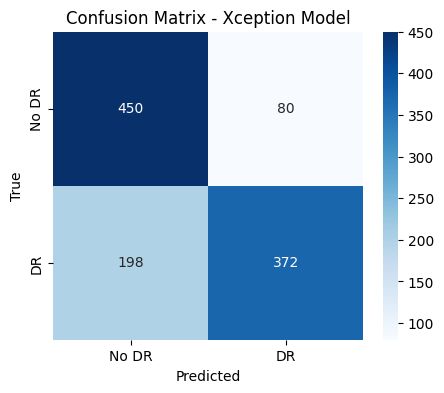

In [34]:
results_xception = evaluate_model(model, test_gen, model_name="Xception Model")


# TRAINING GRAPH FUNCTION

In [35]:

def plot_history(history, model_name="Model"):
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.title(f"{model_name} — Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"{model_name} — Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.show()


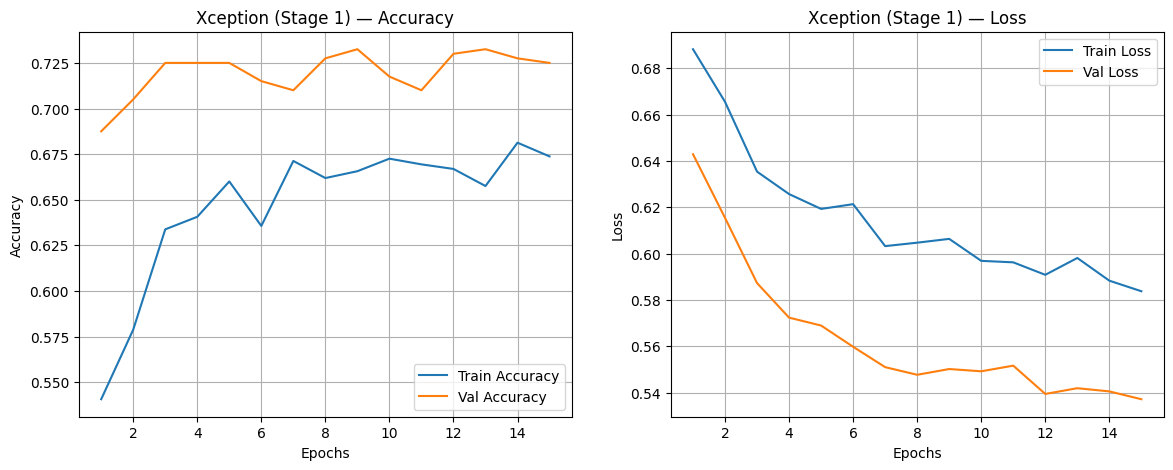

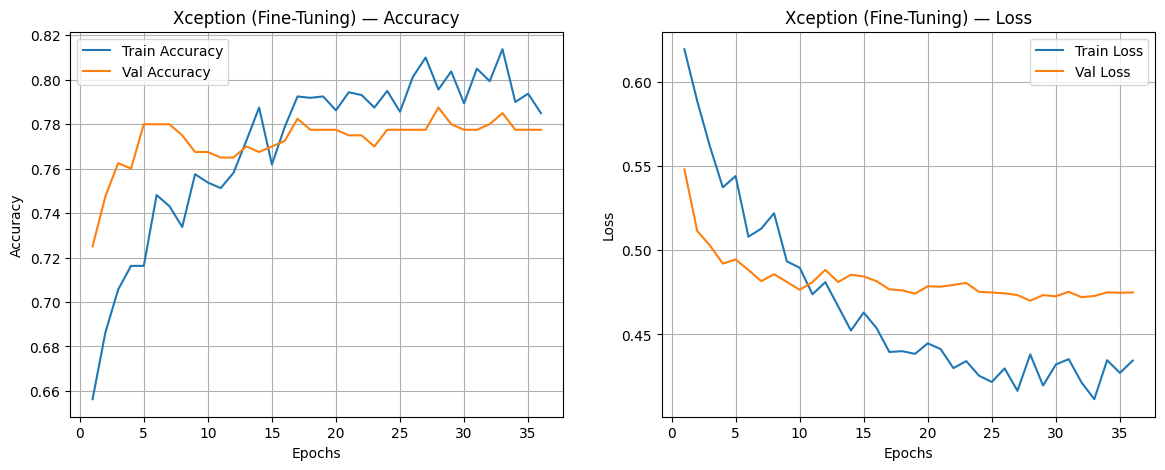

In [36]:
plot_history(history1, "Xception (Stage 1)")
plot_history(history2, "Xception (Fine-Tuning)")


# LOAD XCEPTION MODEL

In [19]:

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception 
import preprocess_input as xcep_preprocess

model_path = "/kaggle/working/xception_dr_model.h5"
xception_model = load_model(model_path, compile=False)

print("Model loaded successfully!")


Model loaded successfully!


# Testing model

In [21]:
import cv2
import numpy as np

IMG_SIZE = (299, 299)

def preprocess_xception_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found: " + img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    # CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)

    # Xception preprocessing (-1 to 1)
    img = xcep_preprocess(img)

    img = np.expand_dims(img, axis=0)
    return img


In [22]:
def predict_dr_xception(img_path):
    img = preprocess_xception_image(img_path)

    prob = xception_model.predict(img)[0][0]
    label = "DR" if prob >= 0.5 else "No DR"

    print("===================================")
    print("Image:", img_path)
    print("Prediction:", label)
    print("Probability (DR): {:.4f}".format(prob))
    print("===================================")

    return label, prob


In [29]:
test_image = "/kaggle/input/drtid-data/DRTiD/Original Images/0019_1.jpg"
predict_dr_xception(test_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: /kaggle/input/drtid-data/DRTiD/Original Images/0019_1.jpg
Prediction: DR
Probability (DR): 0.7526


('DR', 0.752636)

**localization**

# **localization**

In [7]:
import pandas as pd
import numpy as np
import os

# Path to localization CSV (adjust if needed)
LOC_CSV = "/kaggle/input/drtid-data/DRTiD/Ground Truths/Optic_Macula_Localization/op_ma_localization.csv"

loc_df = pd.read_csv(LOC_CSV)

# --- clean column names if they have '#' or spaces ---
loc_df.columns = [c.strip().lstrip('# ').replace(' ', '') for c in loc_df.columns]
print(loc_df.columns)

# Expect something like:
# ['image','opticdisc_x','opticdisc_y','opticdisc_h','opticdisc_w',
#  'macula_x','macula_y','macula_h','macula_w']

# Add full filename column, to match images in Original Images
loc_df["filename"] = loc_df["image"].astype(str)

# Keep only what we need
bbox_cols = [
    "opticdisc_x","opticdisc_y","opticdisc_h","opticdisc_w",
    "macula_x","macula_y","macula_h","macula_w"
]

loc_df = loc_df[["filename"] + bbox_cols]
loc_df.head()


Index(['image', 'opticdisc_x', 'opticdisc_y', 'opticdisc_h', 'opticdisc_w',
       'macula_x', 'macula_y', 'macula_h', 'macula_w'],
      dtype='object')


,filename,opticdisc_x,opticdisc_y,opticdisc_h,opticdisc_w,macula_x,macula_y,macula_h,macula_w
0,0002_1.jpg,0.187372,0.467684,0.143661,0.146329,0.514826,0.523526,0.102249,0.098759
1,0002_2.jpg,0.519683,0.494829,0.147751,0.146846,0.864008,0.521200,0.123722,0.124095
2,0003_1.jpg,0.162832,0.501293,0.139571,0.125646,0.466769,0.523009,0.091002,0.079111
3,0003_2.jpg,0.504346,0.510341,0.129346,0.114788,0.817229,0.521200,0.093558,0.087901
4,0004_1.jpg,0.151074,0.477508,0.136503,0.150465,0.500000,0.546536,0.133947,0.125129


In [8]:
from sklearn.model_selection import train_test_split

train_loc_df, val_loc_df = train_test_split(
    loc_df,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

print("Train loc samples:", len(train_loc_df))
print("Val   loc samples:", len(val_loc_df))


Train loc samples: 2480
Val   loc samples: 620


In [9]:
def clahe_xception(img):
    img = img.astype(np.uint8)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    cl = clahe.apply(l)

    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)

    img = xcep_preprocess(img)   # NORMALIZED [-1, 1]
    return img


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

loc_datagen = ImageDataGenerator(
    preprocessing_function=clahe_xception
)

loc_train_flow = loc_datagen.flow_from_dataframe(
    train_loc_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col=bbox_cols,           # 8 regression targets
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",          # returns 8-dim vector
    shuffle=True,
    seed=SEED
)

loc_val_flow = loc_datagen.flow_from_dataframe(
    val_loc_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col=bbox_cols,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)


Found 2480 validated image filenames.
Found 620 validated image filenames.


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception

tf.keras.backend.clear_session()

loc_base = Xception(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
loc_base.trainable = False   # Stage 1: feature extractor

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = loc_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)

# 8 outputs (normalized bbox values), no activation or "sigmoid" if you want strict 0–1
outputs = layers.Dense(8, activation="sigmoid")(x)

loc_model = models.Model(inputs, outputs)
loc_model.summary()


I0000 00:00:1764161101.427646      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764161101.428225      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,043,952 (84.09 MB)

 Trainable params: 1,182,472 (4.51 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [12]:
from tensorflow.keras.applications.xception import preprocess_input as xcep_preprocess

loc_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mse",
    metrics=["mae"]
)

cb_loc1 = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, verbose=1)
]

history_loc1 = loc_model.fit(
    loc_train_flow,
    epochs=20,
    validation_data=loc_val_flow,
    callbacks=cb_loc1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1764161117.664631     112 service.cc:148] XLA service 0x7be710440740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764161117.665492     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764161117.665518     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764161118.705596     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-26 12:45:22.330137: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[16,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0

  1/155 ━━━━━━━━━━━━━━━━━━━━ 45:27 18s/step - loss: 0.0657 - mae: 0.2210

I0000 00:00:1764161128.035441     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


155/155 ━━━━━━━━━━━━━━━━━━━━ 101s 539ms/step - loss: 0.0252 - mae: 0.1100 - val_loss: 0.0144 - val_mae: 0.0677 - learning_rate: 1.0000e-04
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 381ms/step - loss: 0.0155 - mae: 0.0773 - val_loss: 0.0145 - val_mae: 0.0705 - learning_rate: 1.0000e-04
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 60s 384ms/step - loss: 0.0148 - mae: 0.0728 - val_loss: 0.0140 - val_mae: 0.0731 - learning_rate: 1.0000e-04
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 375ms/step - loss: 0.0139 - mae: 0.0700 - val_loss: 0.0134 - val_mae: 0.0694 - learning_rate: 1.0000e-04
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 392ms/step - loss: 0.0132 - mae: 0.0683 - val_loss: 0.0130 - val_mae: 0.0734 - learning_rate: 1.0000e-04
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 375ms/step - loss: 0.0131 - mae: 0.0674 - val_loss: 0.0123 - val_mae: 0.0720 - learning_rate: 1.0000e-04
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 60s 385ms/step - loss: 0.0122 - mae: 0.0651 - val_loss: 0.0121 - val_mae: 0.

In [16]:
# Fine-tune last 60 layers of Xception
loc_base.trainable = True
for layer in loc_base.layers[:-60]:
    layer.trainable = False

loc_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="mse",
    metrics=["mae"]
)

cb_loc2 = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
]

history_loc2 = loc_model.fit(
    loc_train_flow,
    epochs=40,
    validation_data=loc_val_flow,
    callbacks=cb_loc2
)


Epoch 1/40


E0000 00:00:1764141349.943665     131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764141350.085792     131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


155/155 ━━━━━━━━━━━━━━━━━━━━ 87s 415ms/step - loss: 0.0133 - mae: 0.0696 - val_loss: 0.0053 - val_mae: 0.0454 - learning_rate: 1.0000e-05
Epoch 2/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 392ms/step - loss: 0.0062 - mae: 0.0506 - val_loss: 0.0046 - val_mae: 0.0449 - learning_rate: 1.0000e-05
Epoch 3/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 60s 388ms/step - loss: 0.0046 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0429 - learning_rate: 1.0000e-05
Epoch 4/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 391ms/step - loss: 0.0039 - mae: 0.0426 - val_loss: 0.0036 - val_mae: 0.0408 - learning_rate: 1.0000e-05
Epoch 5/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 383ms/step - loss: 0.0034 - mae: 0.0398 - val_loss: 0.0032 - val_mae: 0.0389 - learning_rate: 1.0000e-05
Epoch 6/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 382ms/step - loss: 0.0028 - mae: 0.0379 - val_loss: 0.0030 - val_mae: 0.0375 - learning_rate: 1.0000e-05
Epoch 7/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 63s 405ms/step - loss: 0.0028 - mae: 0.0372 - val_loss: 0.0028 - val_mae: 0.0

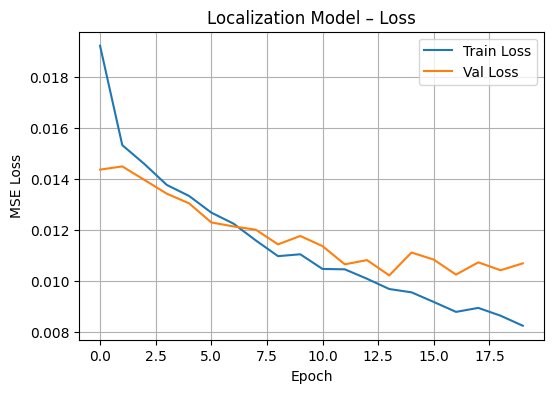

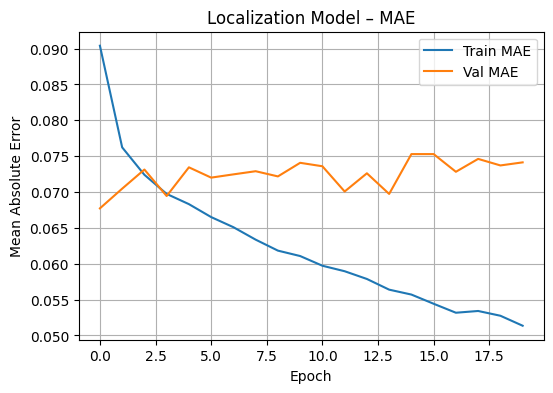

In [15]:
import matplotlib.pyplot as plt

# ---- Loss curves ----
plt.figure(figsize=(6,4))
plt.plot(history_loc1.history["loss"], label="Train Loss")
plt.plot(history_loc1.history["val_loss"], label="Val Loss")
plt.title("Localization Model – Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---- MAE curves ----
if "mae" in history_loc1.history:
    plt.figure(figsize=(6,4))
    plt.plot(history_loc1.history["mae"], label="Train MAE")
    plt.plot(history_loc1.history["val_mae"], label="Val MAE")
    plt.title("Localization Model – MAE")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No 'mae' metric found in history_loc1.history keys:", history_loc1.history.keys())


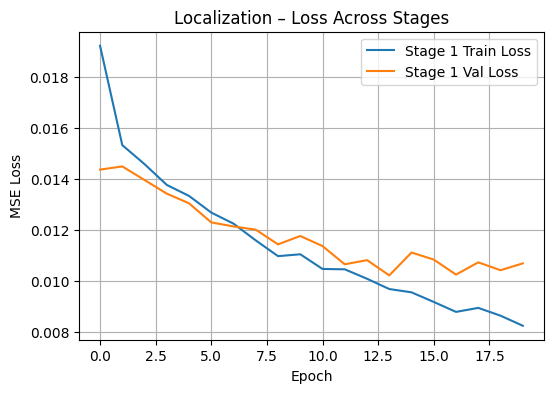

In [16]:
def plot_loc_history(histories, labels):
    plt.figure(figsize=(6,4))
    for h, lab in zip(histories, labels):
        plt.plot(h.history["loss"], label=f"{lab} Train Loss")
        plt.plot(h.history["val_loss"], label=f"{lab} Val Loss")
    plt.title("Localization – Loss Across Stages")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loc_history([history_loc1], ["Stage 1"])
# if you have history_loc2: plot_loc_history([history_loc1, history_loc2], ["Stage 1", "Stage 2"])


In [17]:
loc_model.save("xception_localization_model.h5")


Found 1 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


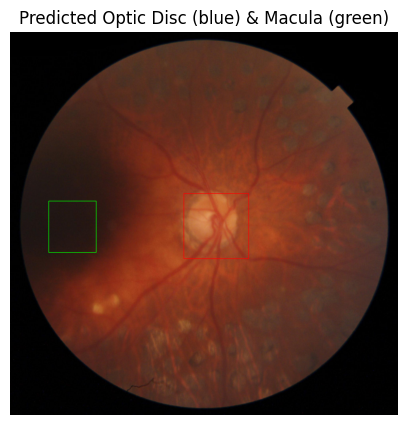

In [18]:
import matplotlib.pyplot as plt

def draw_boxes(img_path, preds):
    # preds: [optic_x, optic_y, optic_h, optic_w, mac_x, mac_y, mac_h, mac_w] in [0,1]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    optic_x, optic_y, optic_h, optic_w, mac_x, mac_y, mac_h, mac_w = preds

    # convert normalized center+size to pixel boxes
    def to_box(cx, cy, hh, ww):
        cx, cy, hh, ww = cx*w, cy*h, hh*h, ww*w
        x1 = int(cx - ww/2)
        y1 = int(cy - hh/2)
        x2 = int(cx + ww/2)
        y2 = int(cy + hh/2)
        return x1, y1, x2, y2

    ox1, oy1, ox2, oy2 = to_box(optic_x, optic_y, optic_h, optic_w)
    mx1, my1, mx2, my2 = to_box(mac_x, mac_y, mac_h, mac_w)

    img_box = img.copy()
    cv2.rectangle(img_box, (ox1, oy1), (ox2, oy2), (255, 0, 0), 2)  # optic: blue/red
    cv2.rectangle(img_box, (mx1, my1), (mx2, my2), (0, 255, 0), 2)  # macula: green

    plt.figure(figsize=(5,5))
    plt.imshow(img_box)
    plt.axis("off")
    plt.title("Predicted Optic Disc (blue) & Macula (green)")
    plt.show()

# Example on one image from val set
sample_row = val_loc_df.sample(1, random_state=SEED).iloc[0]
sample_path = os.path.join(IMG_DIR, sample_row["filename"])

img_batch = loc_datagen.flow_from_dataframe(
    pd.DataFrame([sample_row]),
    directory=IMG_DIR,
    x_col="filename",
    y_col=bbox_cols,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="raw",
    shuffle=False
)

preds = loc_model.predict(img_batch)[0]
draw_boxes(sample_path, preds)


Model Loaded Successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Raw Predictions: [0.8512383  0.4927763  0.1754751  0.18401825 0.49145487 0.5110014
 0.12547857 0.12906703]


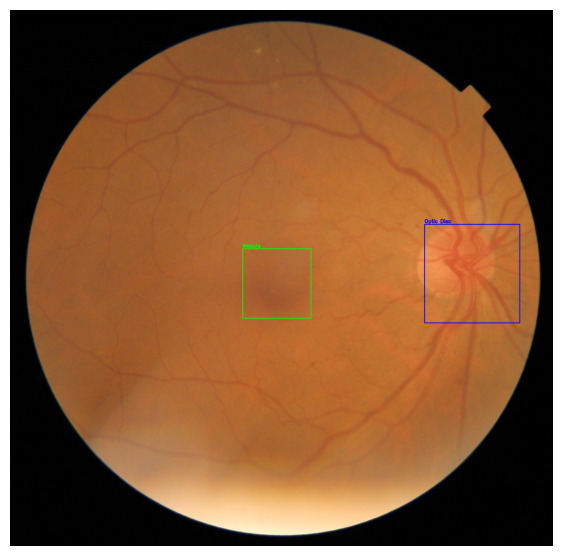

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input as xcep_preprocess

# ----------------------------
# 1. Load Model
# ----------------------------
MODEL_PATH = "/kaggle/working/xception_localization_model.h5"
model = load_model(MODEL_PATH, compile=False)

IMG_SIZE = (299, 299)

print("Model Loaded Successfully!")


# ----------------------------
# 2. Preprocess Function
# ----------------------------
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found at:", img_path)

    orig = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(orig, IMG_SIZE)

    # --- CLAHE ---
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)

    # Xception preprocessing
    img = xcep_preprocess(img)

    return orig, np.expand_dims(img, axis=0)


# ----------------------------
# 3. Draw Bounding Boxes
# ----------------------------
def draw_boxes(image, preds):
    h, w, _ = image.shape

    # Extract predictions
    od_x, od_y, od_w, od_h, ma_x, ma_y, ma_w, ma_h = preds

    # Convert normalized → pixel coordinates
    od_x1 = int((od_x - od_w/2) * w)
    od_y1 = int((od_y - od_h/2) * h)
    od_x2 = int((od_x + od_w/2) * w)
    od_y2 = int((od_y + od_h/2) * h)

    ma_x1 = int((ma_x - ma_w/2) * w)
    ma_y1 = int((ma_y - ma_h/2) * h)
    ma_x2 = int((ma_x + ma_w/2) * w)
    ma_y2 = int((ma_y + ma_h/2) * h)

    # Draw OD box (blue)
    cv2.rectangle(image, (od_x1, od_y1), (od_x2, od_y2), (0, 0, 255), 2)
    cv2.putText(image, "Optic Disc", (od_x1, od_y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Draw MA box (green)
    cv2.rectangle(image, (ma_x1, ma_y1), (ma_x2, ma_y2), (0, 255, 0), 2)
    cv2.putText(image, "Macula", (ma_x1, ma_y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    return image


# ----------------------------
# 4. Predict on a Single Image
# ----------------------------
def localize(img_path):
    orig, prep = preprocess_image(img_path)

    preds = model.predict(prep)[0]
    print("Raw Predictions:", preds)

    result = draw_boxes(orig.copy(), preds)

    plt.figure(figsize=(7,7))
    plt.imshow(result)
    plt.axis("off")
    plt.show()


# ----------------------------
# 5. Run on Test Image
# ----------------------------
test_image_path = "/kaggle/input/drtid-data/DRTiD/Original Images/0019_1.jpg"   # <-- CHANGE THIS
localize(test_image_path)


# **Labels + Localization**

In [38]:
# ---------------------------
# === USER CONFIGURE HERE ===
# ---------------------------
IMG_DIR = "/kaggle/input/drtid-data/DRTiD/Original Images"   # path to images
TRAIN_CSV = "/kaggle/input/drtid-data/DRTiD/Ground Truths/DR_grade/a. DR_grade_Training.csv"   # training CSV (grades)
LOC_CSV   = "/kaggle/input/drtid-data/DRTiD/Ground Truths/Optic_Macula_Localization/op_ma_localization.csv"  # localization CSV
IMG_SIZE = (299, 299)   # Xception expects 299x299
BATCH_SIZE = 16
SEED = 42
EPOCHS_STAGE1 = 12
EPOCHS_STAGE2 = 30
CLASS_LOSS_WEIGHT = 1.0
LOC_LOSS_WEIGHT = 50.0   # scale localization loss (tuneable)
MODEL_SAVE_PATH = "/kaggle/working/unified_xception_dr_loc.h5"

In [39]:
# ---------------------------
# Utilities: CLAHE preprocessing (same style used earlier)
# ---------------------------
def clahe_preprocess_for_model(img_bgr):
    # img_bgr: loaded by cv2.imread
    if img_bgr is None:
        raise ValueError("Image is None")
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    cl = clahe.apply(l.astype(np.uint8))
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)
    img = xcep_preprocess(img)   # -1..1 scaling + channel norm used by Xception
    return img


In [40]:
# ---------------------------
# Build merged dataframe for train/test with labels + localization
# ---------------------------
def build_merged_df(train_csv, loc_csv, img_dir):
    # train_csv: contains at least columns "ID", "Macula", "Optic disc", "Grade" OR similar.
    # We will create an expanded dataframe containing 'filename' and binary 'label'
    train_raw = pd.read_csv(train_csv)
    loc_df = pd.read_csv(loc_csv)

    # Standardize column names for localization CSV:
    # The provided loc CSV uses columns like 'image', 'opticdisc_x', 'opticdisc_y', 'opticdisc_h', 'opticdisc_w',
    # 'macula_x','macula_y','macula_h','macula_w' (normalized coordinates). We will try to detect them.
    loc_df_columns = [c.lower() for c in loc_df.columns]

    # Normalize column names mapping if needed (robust to slight naming differences)
    # Required final names in loc_df: image, od_cx, od_cy, od_w, od_h, ma_cx, ma_cy, ma_w, ma_h
    # Try common header names:
    rename_map = {}
    # image column
    for c in loc_df.columns:
        if c.lower() in ("image","filename","file"):
            rename_map[c] = "image"
    # optic disc
    for c in loc_df.columns:
        lc = c.lower()
        if "opticdisc" in lc or "optic_disc" in lc or "od_" in lc:
            if "x" in lc and "cx" not in lc:
                rename_map[c] = "od_cx"
            if "y" in lc and "cy" not in lc:
                rename_map[c] = "od_cy"
            if "w" in lc and "width" not in lc:
                rename_map[c] = "od_w"
            if "h" in lc and "height" not in lc:
                rename_map[c] = "od_h"
    # macula
    for c in loc_df.columns:
        lc = c.lower()
        if "macula" in lc or "ma_" in lc:
            if "x" in lc and "cx" not in lc:
                rename_map[c] = "ma_cx"
            if "y" in lc and "cy" not in lc:
                rename_map[c] = "ma_cy"
            if "w" in lc and "width" not in lc:
                rename_map[c] = "ma_w"
            if "h" in lc and "height" not in lc:
                rename_map[c] = "ma_h"

    # If rename_map misses keys, try simple fallback names
    # If loc csv already has nice names, skip
    loc_df = loc_df.rename(columns=rename_map)
    required_loc_cols = ["image","od_cx","od_cy","od_w","od_h","ma_cx","ma_cy","ma_w","ma_h"]
    if not all(c in loc_df.columns for c in required_loc_cols):
        # Try to guess common alternative names exactly
        alt_map = {}
        for c in loc_df.columns:
            lc = c.lower()
            if "optic" in lc and "x" in lc:
                alt_map[c] = "od_cx"
            if "optic" in lc and "y" in lc:
                alt_map[c] = "od_cy"
            if "optic" in lc and "w" in lc:
                alt_map[c] = "od_w"
            if "optic" in lc and "h" in lc:
                alt_map[c] = "od_h"
            if "macula" in lc and "x" in lc:
                alt_map[c] = "ma_cx"
            if "macula" in lc and "y" in lc:
                alt_map[c] = "ma_cy"
            if "macula" in lc and "w" in lc:
                alt_map[c] = "ma_w"
            if "macula" in lc and "h" in lc:
                alt_map[c] = "ma_h"
        loc_df = loc_df.rename(columns=alt_map)

    # Expand training CSV to macula + optic rows to get binary label mapping
    # We assume train_csv has "Macula","Optic disc","Grade" or similar - try robust mapping:
    tr = train_raw.copy()
    # find grade column
    grade_col = None
    for c in tr.columns:
        if "grade" in c.lower():
            grade_col = c
            break
    if grade_col is None:
        raise ValueError("Could not find Grade column in train CSV")

    # find macula/optic columns in train csv
    mac_col = None
    od_col = None
    for c in tr.columns:
        lc = c.lower()
        if "macula" in lc:
            mac_col = c
        if "optic" in lc or "optic disc" in lc or "optic_disc" in lc:
            od_col = c
    if mac_col is None or od_col is None:
        # fallback: maybe first and second numeric columns are filenames; try common names
        raise ValueError("Could not detect Macula / Optic disc columns in train CSV")

    mac = pd.DataFrame({
        "filename": tr[mac_col].astype(str).str.strip() + ".jpg",
        "label": (tr[grade_col] > 0).astype(int)
    })
    opt = pd.DataFrame({
        "filename": tr[od_col].astype(str).str.strip() + ".jpg",
        "label": (tr[grade_col] > 0).astype(int)
    })
    expanded = pd.concat([mac, opt], ignore_index=True)

    # merge expanded labels with localization data: loc_df.image contains filenames like '0002_1.jpg'
    merged = expanded.merge(loc_df, left_on="filename", right_on="image", how="inner")
    # keep only rows where images exist
    merged = merged[merged["filename"].apply(lambda f: os.path.exists(os.path.join(IMG_DIR, f)))]
    merged = merged.reset_index(drop=True)
    # Ensure numeric columns are floats
    for c in ["od_cx","od_cy","od_w","od_h","ma_cx","ma_cy","ma_w","ma_h"]:
        merged[c] = merged[c].astype(float)

    return merged


In [43]:
# ---------------------------
# Keras Sequence generator for multi-output
# ---------------------------
from tensorflow.keras.utils import Sequence
class DRLocSequence(Sequence):
    def __init__(self, df, img_dir, batch_size=16, shuffle=True, augment=False, seed=SEED):
        self.df = df.reset_index(drop=True).copy()
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.df))
        self.rng = np.random.RandomState(seed)
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            self.rng.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_idx = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_df = self.df.iloc[batch_idx]
        imgs = []
        y_cls = []
        y_loc = []
        for _, row in batch_df.iterrows():
            p = os.path.join(self.img_dir, row["filename"])
            img_bgr = cv2.imread(p)
            if img_bgr is None:
                # skip image: insert zeros
                img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
            else:
                img = clahe_preprocess_for_model(img_bgr)  # already returns preprocessed -1..1
            # simple augmentation (optional)
            if self.augment:
                # random horizontal flip
                if self.rng.rand() < 0.5:
                    img = np.fliplr(img)
                    # also flip x coordinates in localization: x -> 1 - x - width  (if normalized)
                    # But we will not augment loc coordinates here in this simple example.
                # (More complex augmentation needs corresponding bbox transforms)
                pass
            imgs.append(img)
            y_cls.append(float(row["label"]))
            # localization order: od_cx, od_cy, od_w, od_h, ma_cx, ma_cy, ma_w, ma_h
            y_loc.append([
                row["od_cx"], row["od_cy"], row["od_w"], row["od_h"],
                row["ma_cx"], row["ma_cy"], row["ma_w"], row["ma_h"]
            ])
        imgs = np.stack(imgs, axis=0).astype(np.float32)
        y_cls = np.array(y_cls).astype(np.float32)
        y_loc = np.array(y_loc).astype(np.float32)
        # Return a dict of outputs (names must match model compile names)
        return imgs, {"cls": y_cls, "loc": y_loc}


In [44]:

# ---------------------------
# IoU helper (boxes in normalized cx,cy,w,h)
# ---------------------------
def cxcywh_to_xyxy(box, img_shape=(299,299)):
    cx, cy, w, h = box
    W, H = img_shape[1], img_shape[0]
    x1 = (cx - w/2.0) * W
    y1 = (cy - h/2.0) * H
    x2 = (cx + w/2.0) * W
    y2 = (cy + h/2.0) * H
    return [x1,y1,x2,y2]

def iou_from_boxes(boxA, boxB, img_shape=(299,299)):
    a = cxcywh_to_xyxy(boxA, img_shape)
    b = cxcywh_to_xyxy(boxB, img_shape)
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])
    interW = max(0.0, xB - xA)
    interH = max(0.0, yB - yA)
    interArea = interW * interH
    boxAArea = max(0.0, (a[2]-a[0]) * (a[3]-a[1]))
    boxBArea = max(0.0, (b[2]-b[0]) * (b[3]-b[1]))
    union = boxAArea + boxBArea - interArea
    if union <= 0:
        return 0.0
    return interArea / union


In [46]:
# ---------------------------
# Build unified model (Xception backbone)
# ---------------------------
def build_unified_model(img_size=(299,299,3), base_trainable=False):
    tf.keras.backend.clear_session()
    gc.collect()
    base = Xception(weights="imagenet", include_top=False, input_shape=img_size)
    base.trainable = base_trainable  # stage 1: False; stage 2: unfreeze last layers manually
    inp = layers.Input(shape=img_size)
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    shared_feat = layers.Dense(128, activation="relu")(x)

    # classification head
    cls = layers.Dense(64, activation="relu")(shared_feat)
    cls = layers.Dropout(0.25)(cls)
    cls_out = layers.Dense(1, activation="sigmoid", name="cls")(cls)

    # localization head (predict 8 normalized values)
    loc = layers.Dense(128, activation="relu")(shared_feat)
    loc = layers.Dropout(0.25)(loc)
    loc_out = layers.Dense(8, activation="sigmoid", name="loc")(loc)
    # Note: using sigmoid forces outputs in 0..1 range (suitable for normalized boxes)

    model = models.Model(inputs=inp, outputs=[cls_out, loc_out])
    return model, base


In [47]:

# ---------------------------
# Prepare dataframes and generators
# ---------------------------
print("Preparing dataframes...")
merged = build_merged_df(TRAIN_CSV, LOC_CSV, IMG_DIR)
print("Merged rows:", len(merged))


Preparing dataframes...
Merged rows: 2000


In [48]:

# split into train/val simple split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(merged, test_size=0.15, random_state=SEED, stratify=merged["label"])

train_seq = DRLocSequence(train_df, IMG_DIR, batch_size=BATCH_SIZE, shuffle=True, augment=False)
val_seq = DRLocSequence(val_df, IMG_DIR, batch_size=BATCH_SIZE, shuffle=False, augment=False)


In [49]:

# compute class weights (optional) for binary classification head
cw = compute_class_weight("balanced", classes=np.array([0,1]), y=train_df["label"].values)
class_weights = {0: float(cw[0]), 1: float(cw[1])}
print("class_weights:", class_weights)


class_weights: {0: 1.037851037851038, 1: 0.9648127128263337}


In [50]:
# ---------------------------
# Build, compile and stage1 train
# ---------------------------
model, base = build_unified_model(img_size=IMG_SIZE + (3,), base_trainable=False)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 10, 10,    │ 20,861,480 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Dense)         │ (None, 1)         │         65 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loc (Dense)         │ (None, 8)         │      1,032 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,002,097 (83.93 MB)

 Trainable params: 1,140,617 (4.35 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [54]:
import gc
import math
from tensorflow.keras.utils import Sequence

In [55]:
# compile with multi-loss
from tensorflow.keras import layers, models, callbacks
losses = {
    "cls": "binary_crossentropy",
    "loc": "mse"   # mean squared error for normalized bounding boxes
}
loss_weights = {"cls": CLASS_LOSS_WEIGHT, "loc": LOC_LOSS_WEIGHT}
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=losses, loss_weights=loss_weights, metrics={"cls":"accuracy"})

cb = [
    callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    callbacks.EarlyStopping(patience=6, restore_best_weights=True, verbose=1)
]

print("Starting Stage 1 training (feature extraction head)...")
history_stage1 = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=EPOCHS_STAGE1,
    callbacks=cb,
    # since we have multi-output, class_weight only applies to single-output fit; here's a trick:
    # apply class_weight by duplicating labels in generator is more complex; for now rely on loss_weights.
)


Starting Stage 1 training (feature extraction head)...
Epoch 1/12
107/107 ━━━━━━━━━━━━━━━━━━━━ 68s 517ms/step - cls_accuracy: 0.5015 - cls_loss: 0.7191 - loc_loss: 0.0573 - loss: 3.5830 - val_cls_accuracy: 0.5767 - val_cls_loss: 0.6840 - val_loc_loss: 0.0152 - val_loss: 1.4423 - learning_rate: 1.0000e-04
Epoch 2/12
107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 412ms/step - cls_accuracy: 0.5282 - cls_loss: 0.7068 - loc_loss: 0.0222 - loss: 1.8181 - val_cls_accuracy: 0.5867 - val_cls_loss: 0.6785 - val_loc_loss: 0.0151 - val_loss: 1.4353 - learning_rate: 1.0000e-04
Epoch 3/12
107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 406ms/step - cls_accuracy: 0.5858 - cls_loss: 0.6838 - loc_loss: 0.0197 - loss: 1.6695 - val_cls_accuracy: 0.6233 - val_cls_loss: 0.6627 - val_loc_loss: 0.0145 - val_loss: 1.3863 - learning_rate: 1.0000e-04
Epoch 4/12
107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 407ms/step - cls_accuracy: 0.5838 - cls_loss: 0.6727 - loc_loss: 0.0187 - loss: 1.6061 - val_cls_accuracy: 0.6600 - val_cls_loss: 0.6546 - val_loc_l

In [56]:

# ---------------------------
# Stage 2: fine-tune last layers of backbone
# ---------------------------
print("Unfreezing top layers of backbone for fine-tuning...")
base.trainable = True
# Freeze all layers except last N layers (e.g., last 60)
N_UNFREEZE = 60
for layer in base.layers[:-N_UNFREEZE]:
    layer.trainable = False
for layer in base.layers[-N_UNFREEZE:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=losses, loss_weights=loss_weights, metrics={"cls":"accuracy"})

cb2 = [
    callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
]

history_stage2 = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=EPOCHS_STAGE2,
    callbacks=cb2
)


Unfreezing top layers of backbone for fine-tuning...
Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 90s 557ms/step - cls_accuracy: 0.5984 - cls_loss: 0.6848 - loc_loss: 0.0180 - loss: 1.5856 - val_cls_accuracy: 0.7167 - val_cls_loss: 0.5477 - val_loc_loss: 0.0098 - val_loss: 1.0392 - learning_rate: 1.0000e-05
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 414ms/step - cls_accuracy: 0.7008 - cls_loss: 0.5805 - loc_loss: 0.0123 - loss: 1.1847 - val_cls_accuracy: 0.7233 - val_cls_loss: 0.5429 - val_loc_loss: 0.0075 - val_loss: 0.9191 - learning_rate: 1.0000e-05
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 408ms/step - cls_accuracy: 0.7280 - cls_loss: 0.5383 - loc_loss: 0.0097 - loss: 1.0277 - val_cls_accuracy: 0.7267 - val_cls_loss: 0.5382 - val_loc_loss: 0.0062 - val_loss: 0.8515 - learning_rate: 1.0000e-05
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 410ms/step - cls_accuracy: 0.7669 - cls_loss: 0.5050 - loc_loss: 0.0073 - loss: 0.8672 - val_cls_accuracy: 0.7200 - val_cls_loss: 0.5388 - val_loc_los

In [57]:
# Evaluate classification performance on validation set
# ---------------------------
def evaluate_classification_on_seq(seq, model):
    # collects predictions and truths
    y_true = []
    y_prob = []
    for i in range(len(seq)):
        x_batch, y_batch = seq[i]
        preds = model.predict(x_batch, verbose=0)
        # preds: list [cls_preds, loc_preds]
        cls_preds = preds[0].ravel()
        y_prob.extend(cls_preds.tolist())
        y_true.extend(y_batch["cls"].tolist())
    y_true = np.array(y_true).astype(int)
    y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    print("Accuracy:", (y_pred==y_true).mean())
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    return {"y_true": y_true, "y_prob": y_prob, "y_pred": y_pred, "cm": cm}

print("Evaluating on validation set...")
eval_res = evaluate_classification_on_seq(val_seq, model)


Evaluating on validation set...


Accuracy: 0.7266666666666667
              precision    recall  f1-score   support

           0     0.6864    0.8000    0.7389       145
           1     0.7786    0.6581    0.7133       155

    accuracy                         0.7267       300
   macro avg     0.7325    0.7290    0.7261       300
weighted avg     0.7340    0.7267    0.7256       300

Confusion Matrix:
 [[116  29]
 [ 53 102]]


Mean IoU OD: 0.3409295866261919 MA: 0.27732686687806746


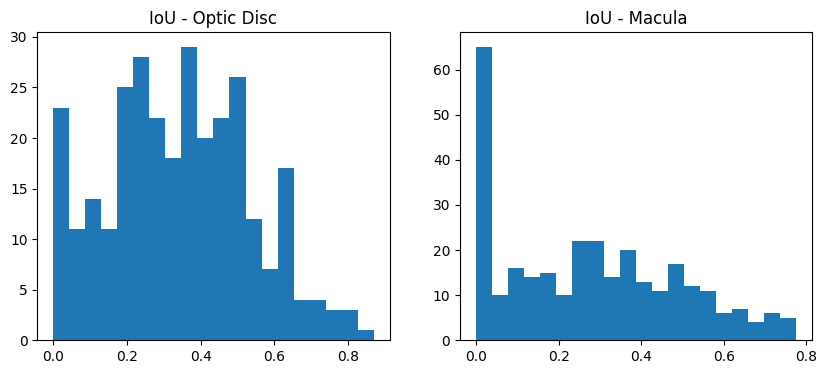

In [58]:
# Evaluate localization IoU on validation (sample)
# ---------------------------
def evaluate_localization_seq(seq, model, n_samples=200):
    ious_od = []
    ious_ma = []
    for i in range(min(len(seq), n_samples)):
        x_batch, y_batch = seq[i]
        preds = model.predict(x_batch, verbose=0)
        loc_preds = preds[1]   # shape (B,8)
        y_loc = y_batch["loc"]
        for b in range(loc_preds.shape[0]):
            pred = loc_preds[b]
            true = y_loc[b]
            od_pred = pred[:4]; ma_pred = pred[4:]
            od_true = true[:4]; ma_true = true[4:]
            ious_od.append(iou_from_boxes(od_true, od_pred, img_shape=IMG_SIZE))
            ious_ma.append(iou_from_boxes(ma_true, ma_pred, img_shape=IMG_SIZE))
    print("Mean IoU OD:", np.mean(ious_od), "MA:", np.mean(ious_ma))
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(ious_od, bins=20); plt.title("IoU - Optic Disc")
    plt.subplot(1,2,2); plt.hist(ious_ma, bins=20); plt.title("IoU - Macula")
    plt.show()
    return {"ious_od": ious_od, "ious_ma": ious_ma}

loc_eval = evaluate_localization_seq(val_seq, model, n_samples=50)


In [59]:
# ---------------------------
# Quick function to run prediction on a single image and draw boxes
# ---------------------------
def predict_and_draw(img_path, model, show=True):
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise ValueError("Image not found")
    inp = np.expand_dims(clahe_preprocess_for_model(bgr), axis=0)
    cls_prob, loc_pred = model.predict(inp)
    cls_prob = float(cls_prob[0,0])
    loc_pred = loc_pred[0]   # 8 normalized values
    od = loc_pred[:4]; ma = loc_pred[4:]
    # convert to xyxy in pixel coords
    od_xy = cxcywh_to_xyxy(od, img_shape=IMG_SIZE)
    ma_xy = cxcywh_to_xyxy(ma, img_shape=IMG_SIZE)
    # draw on original image resized for display (use same scaling)
    disp = cv2.resize(bgr, IMG_SIZE)
    # cv2 uses BGR; drawing colors BGR
    cv2.rectangle(disp, (int(od_xy[0]), int(od_xy[1])), (int(od_xy[2]), int(od_xy[3])), (255,0,0), 3)
    cv2.putText(disp, "Optic", (int(od_xy[0]), int(od_xy[1])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
    cv2.rectangle(disp, (int(ma_xy[0]), int(ma_xy[1])), (int(ma_xy[2]), int(ma_xy[3])), (0,255,0), 3)
    cv2.putText(disp, "Macula", (int(ma_xy[0]), int(ma_xy[1])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
    pred_label = "DR" if cls_prob >= 0.5 else "No DR"
    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(disp, cv2.COLOR_BGR2RGB))
        plt.title(f"{pred_label} ({cls_prob:.3f})")
        plt.axis("off")
        plt.show()
    return {"prob": cls_prob, "loc": loc_pred, "image": disp}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


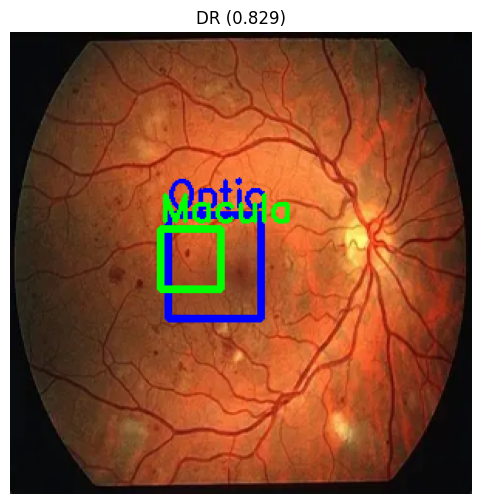

In [61]:
# Example usage:
res = predict_and_draw("/kaggle/input/img-test/dr.webp", model)


In [64]:
model.save("unified_dr_localization_model.h5")
print("Model saved successfully!")


Model saved successfully!
